In [ ]:
# Import all required libraries for data processing, visualization, and machine learning models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import json

In [ ]:
# Load configuration file containing dataset paths and model output directories
with open("config.json", "r") as f:
    config = json.load(f)

In [ ]:
# Load the heart disease dataset from the path specified in config
df = pd.read_csv(config['paths']['input_data']['raw_data'])

EDA and Feature Selection

In [ ]:
# Display basic dataset information and check class distribution for imbalance detection
print(df.info())
print(df['HeartDiseaseorAttack'].value_counts(normalize=True)) # Check for imbalance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

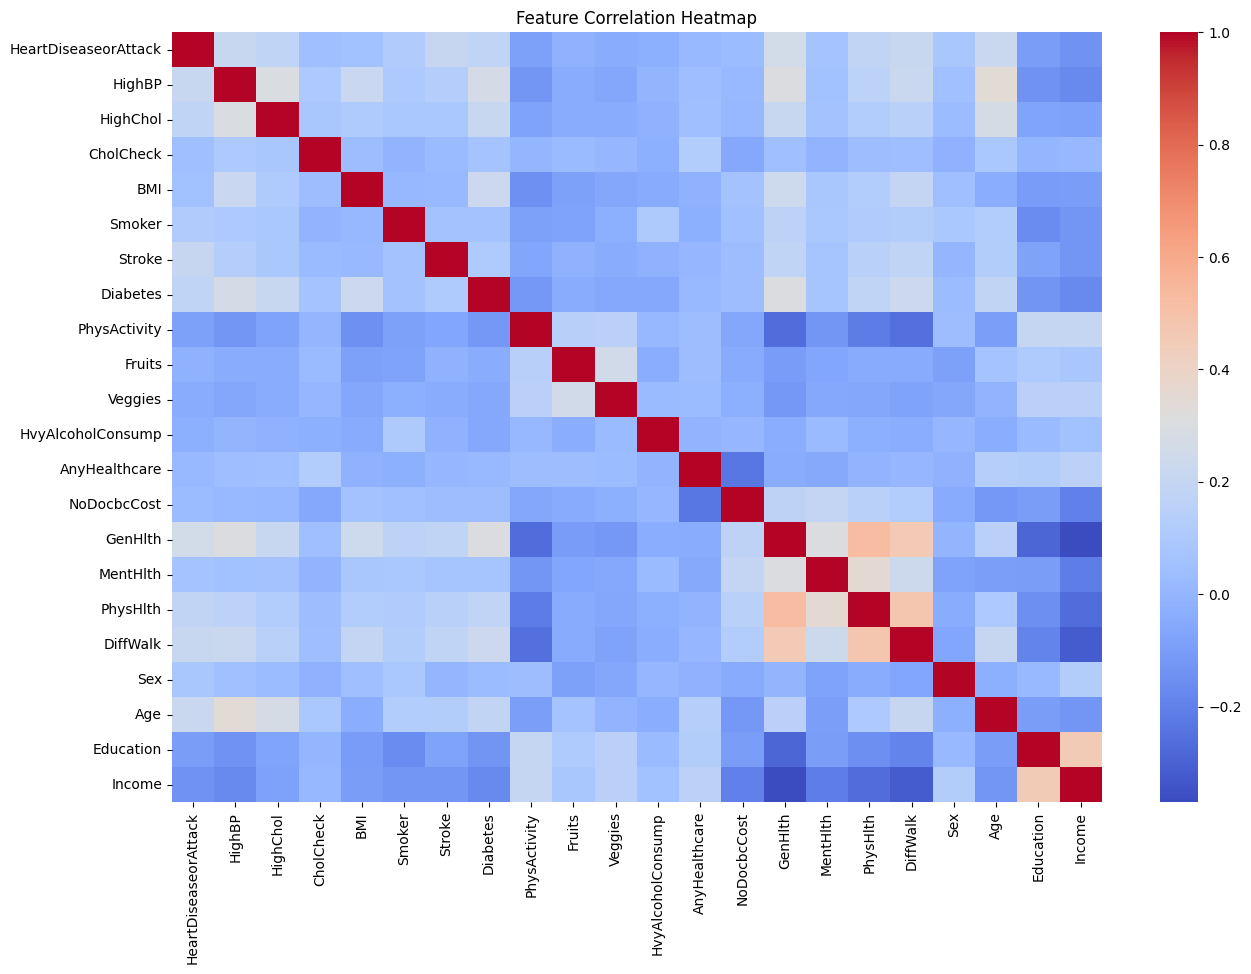

In [ ]:
# Generate correlation heatmap to visualize feature relationships and dependencies
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
# Separate target variable from features and classify columns as numerical or categorical
target = 'HeartDiseaseorAttack'
features = [col for col in df.columns if col != target]

numerical_cols = [col for col in features if df[col].nunique() > 5]
categorical_cols = [col for col in features if df[col].nunique() <= 5]

In [ ]:
# Display all categorical columns identified for exploratory data analysis
categorical_cols

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'Diabetes',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'DiffWalk',
 'Sex']

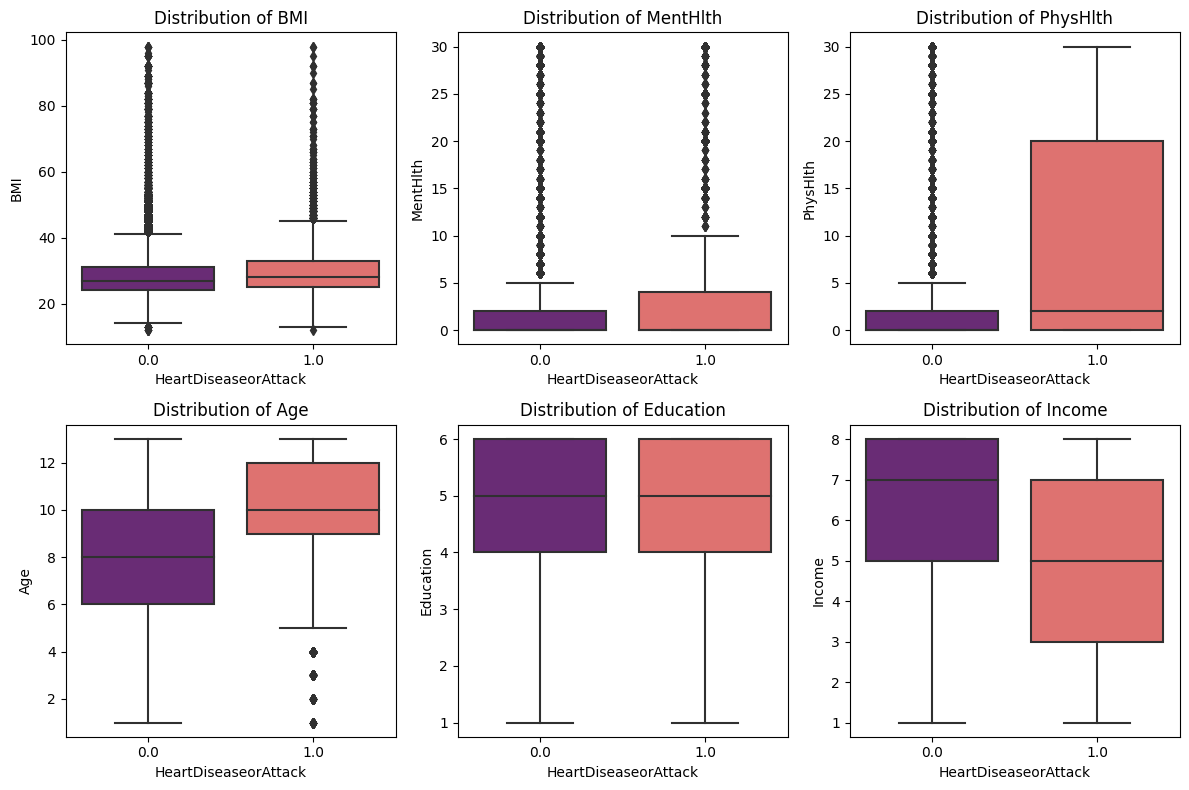

In [ ]:
# Create boxplots for numerical features to visualize their distribution by target variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=target, y=col, data=df, palette='magma')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

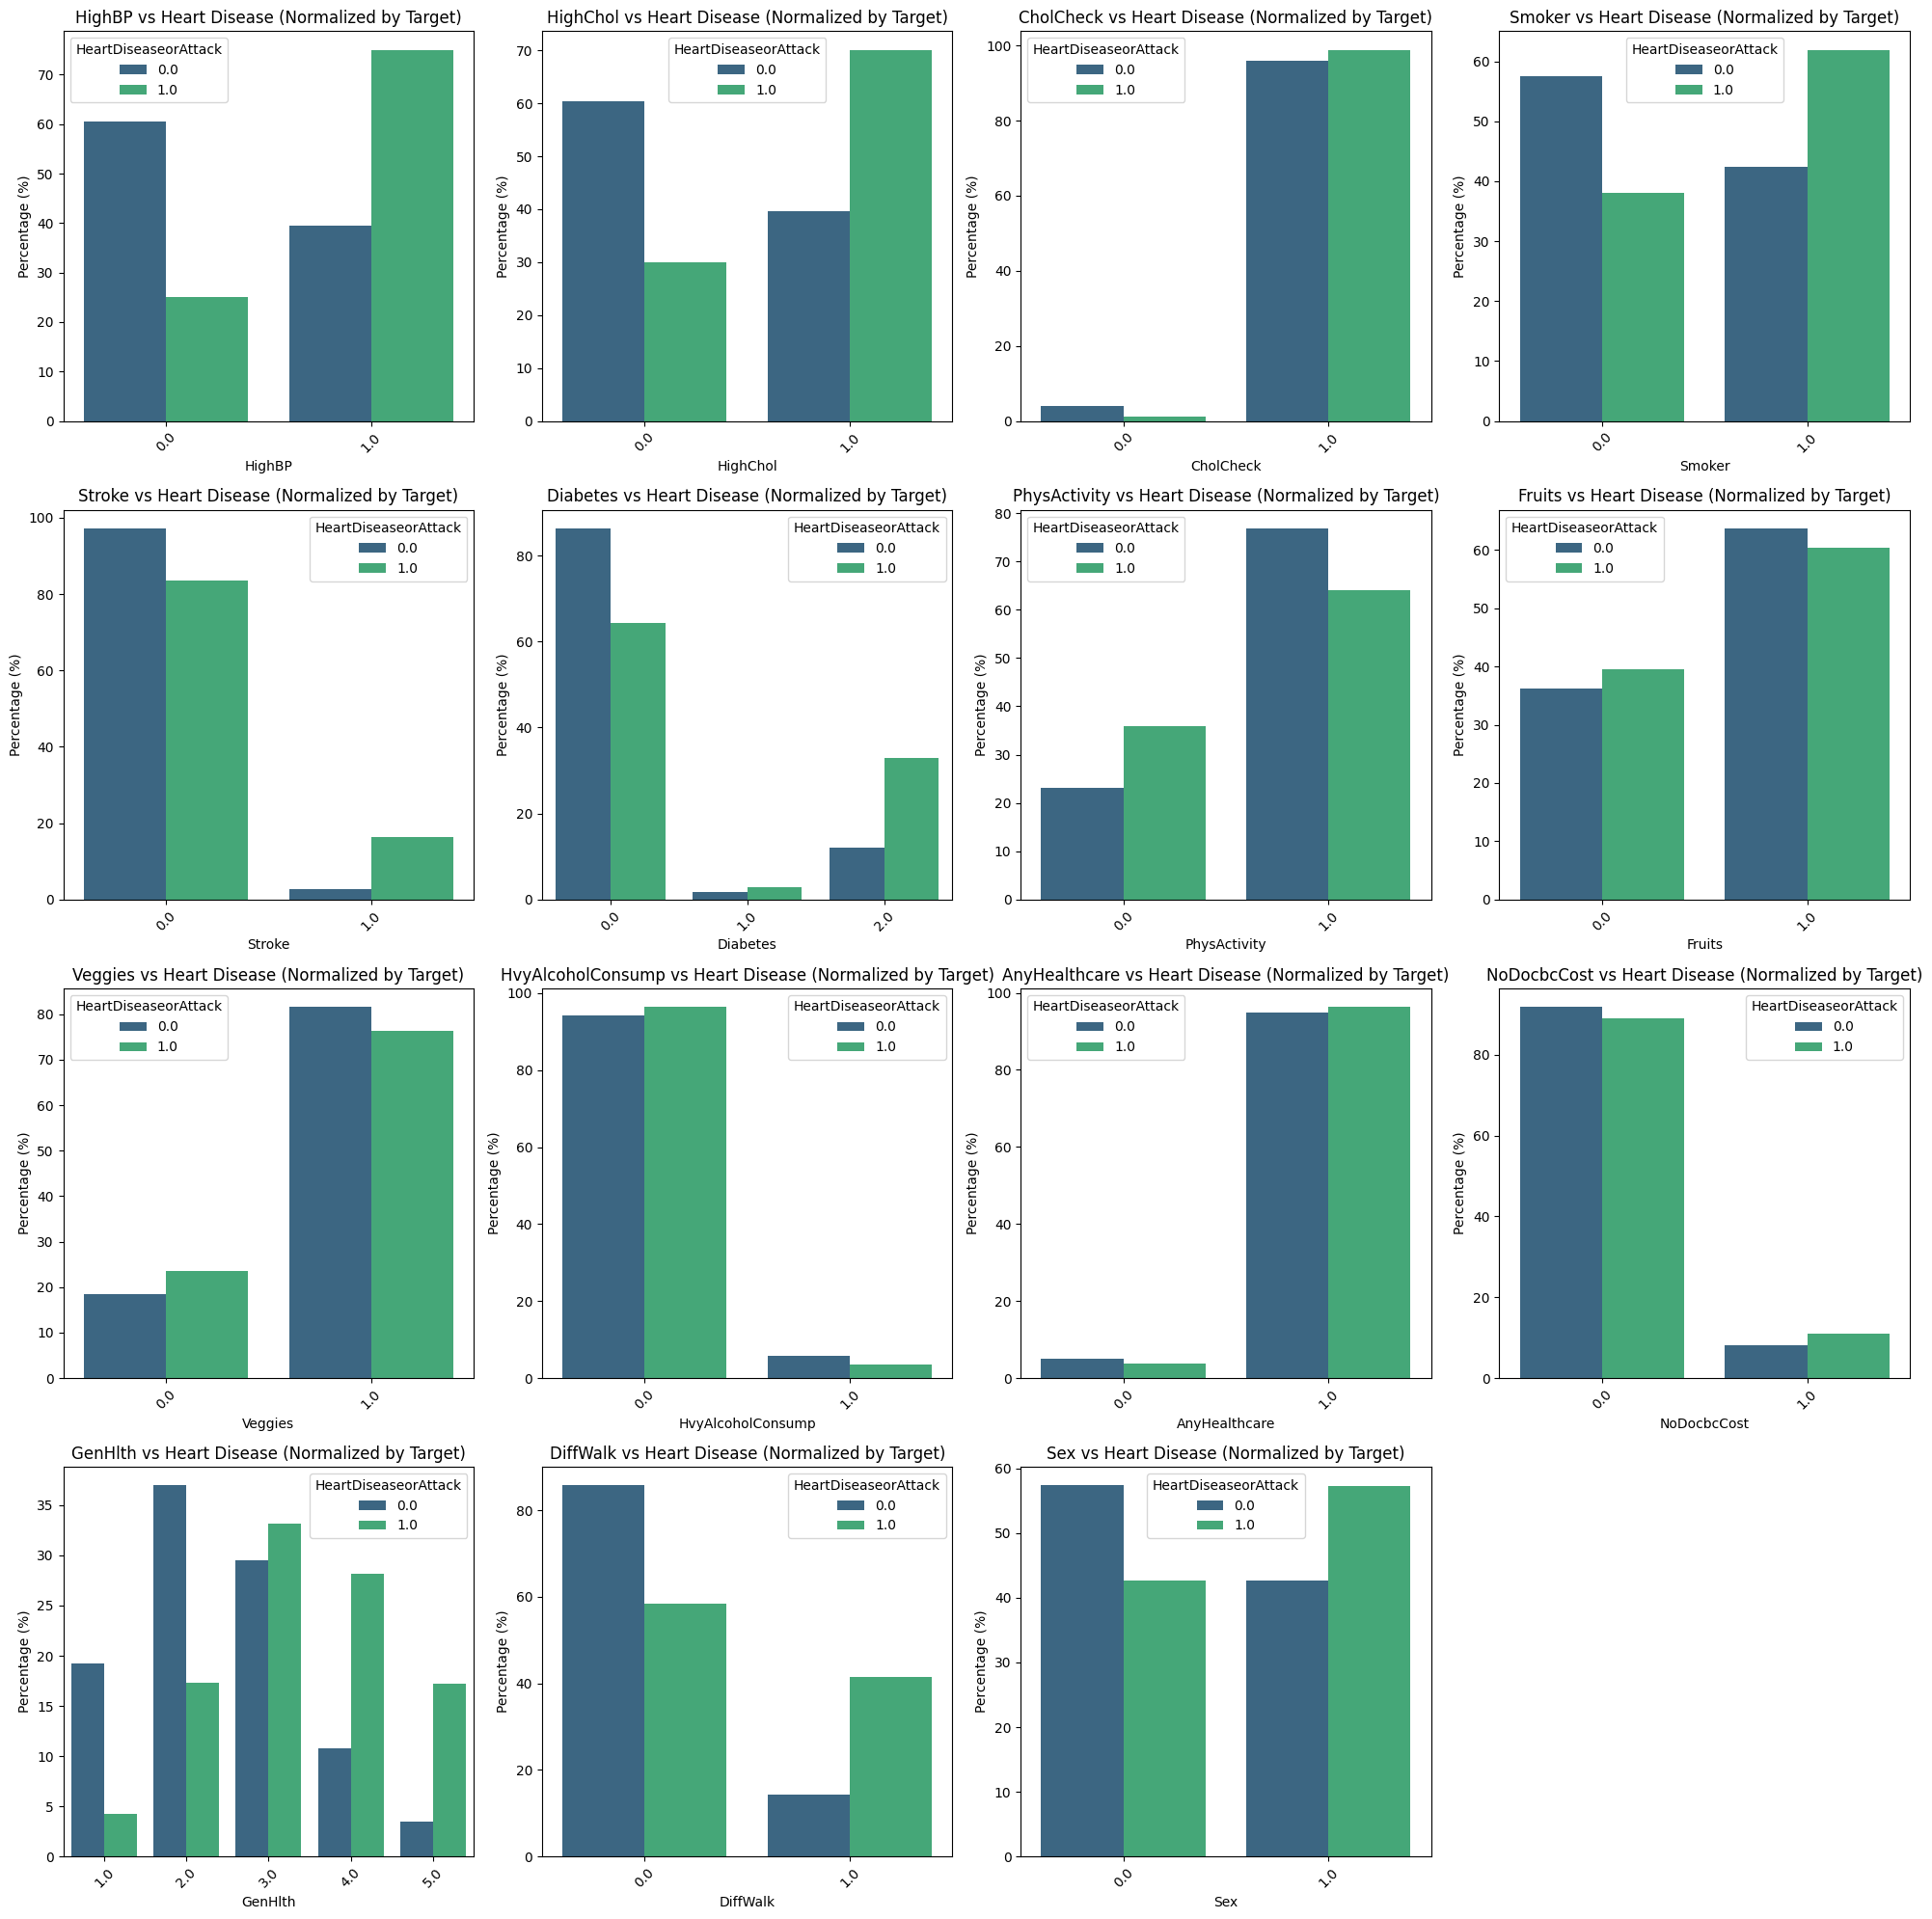

In [ ]:
# Create normalized bar plots for categorical features, showing percentage distribution by target
plt.figure(figsize=(20, 20))

for i, col in enumerate(categorical_cols[:16], 1):
    plt.subplot(4, 4, i)

    # Create normalized percentage table per target
    prop_df = (
        pd.crosstab(df[col], df[target], normalize='columns') * 100
    ).reset_index().melt(
        id_vars=col,
        var_name=target,
        value_name='Percentage'
    )

    sns.barplot(
        data=prop_df,
        x=col,
        y='Percentage',
        hue=target,
        palette='viridis'
    )

    plt.ylabel('Percentage (%)')
    plt.title(f'{col} vs Heart Disease (Normalized by Target)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Select high-impact features based on EDA and domain knowledge for model training
selected_features = [
    'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 
    'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex'
]

X = df[selected_features]
y = df['HeartDiseaseorAttack']

Train-Validation-Test Split

In [ ]:
# Split data into train (67.5%), validation (12.5%), and test (20%) sets with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

Feature Scaling

In [ ]:
# Standardize features using StandardScaler (fit only on training data to prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [ ]:
# Initialize and train Logistic Regression model with balanced class weights
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Make predictions on validation set and calculate performance metrics for Logistic Regression
y_val_pred_lr = log_model.predict(X_val_scaled)
y_val_proba_lr = log_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_lr = {
    "Accuracy": accuracy_score(y_val, y_val_pred_lr),
    "AUC": roc_auc_score(y_val, y_val_proba_lr),
    "Precision": precision_score(y_val, y_val_pred_lr),
    "Recall": recall_score(y_val, y_val_pred_lr),
    "F1": f1_score(y_val, y_val_pred_lr),
    "MCC": matthews_corrcoef(y_val, y_val_pred_lr)
}

print("--- Logistic Regression (Balanced) Results ---")
for metric, value in val_metrics_lr.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_lr))

--- Logistic Regression (Balanced) Results ---
Accuracy: 0.7559
AUC: 0.8458
Precision: 0.2499
Recall: 0.7957
F1: 0.3804
MCC: 0.3490
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     22979
         1.0       0.25      0.80      0.38      2389

    accuracy                           0.76     25368
   macro avg       0.61      0.77      0.61     25368
weighted avg       0.90      0.76      0.80     25368



In [ ]:
# Make predictions on training set and calculate metrics to compare with validation results
y_train_pred_lr = log_model.predict(X_train_scaled)
y_train_proba_lr = log_model.predict_proba(X_train_scaled)[:, 1]

train_metrics_lr = {
    "Accuracy": accuracy_score(y_train, y_train_pred_lr),
    "AUC": roc_auc_score(y_train, y_train_proba_lr),
    "Precision": precision_score(y_train, y_train_pred_lr),
    "Recall": recall_score(y_train, y_train_pred_lr),
    "F1": f1_score(y_train, y_train_pred_lr),
    "MCC": matthews_corrcoef(y_train, y_train_pred_lr)
}

print("--- Logistic Regression (Balanced) Results ---")
for metric, value in train_metrics_lr.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train, y_train_pred_lr))

--- Logistic Regression (Balanced) Results ---
Accuracy: 0.7524
AUC: 0.8468
Precision: 0.2459
Recall: 0.7883
F1: 0.3749
MCC: 0.3417
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    160851
         1.0       0.25      0.79      0.37     16725

    accuracy                           0.75    177576
   macro avg       0.61      0.77      0.61    177576
weighted avg       0.90      0.75      0.80    177576



#### Decision Tree Classifier

In [ ]:
# Initialize and train Decision Tree Classifier with balanced class weights and limited depth
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [ ]:
# Make predictions on validation set and calculate metrics for Decision Tree
y_val_pred_dt = dt_model.predict(X_val_scaled)
y_val_proba_dt = dt_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_dt = {
    "Accuracy": accuracy_score(y_val, y_val_pred_dt),
    "AUC": roc_auc_score(y_val, y_val_proba_dt),
    "Precision": precision_score(y_val, y_val_pred_dt),
    "Recall": recall_score(y_val, y_val_pred_dt),
    "F1": f1_score(y_val, y_val_pred_dt),
    "MCC": matthews_corrcoef(y_val, y_val_pred_dt)
}

print("--- Decision Tree Validation Set Results ---")
for metric, value in val_metrics_dt.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_dt))

--- Decision Tree Validation Set Results ---
Accuracy: 0.7250
AUC: 0.8189
Precision: 0.2268
Recall: 0.7974
F1: 0.3532
MCC: 0.3195
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     22979
         1.0       0.23      0.80      0.35      2389

    accuracy                           0.72     25368
   macro avg       0.60      0.76      0.59     25368
weighted avg       0.90      0.72      0.78     25368



In [ ]:
# Make predictions on training set and calculate metrics for Decision Tree
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_train_proba_dt = dt_model.predict_proba(X_train_scaled)[:, 1]

train_metrics_dt = {
    "Accuracy": accuracy_score(y_train, y_train_pred_dt),
    "AUC": roc_auc_score(y_train, y_train_proba_dt),
    "Precision": precision_score(y_train, y_train_pred_dt),
    "Recall": recall_score(y_train, y_train_pred_dt),
    "F1": f1_score(y_train, y_train_pred_dt),
    "MCC": matthews_corrcoef(y_train, y_train_pred_dt)
}

print("\n--- Decision Tree Final train Results ---")
for metric, value in train_metrics_dt.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train, y_train_pred_dt))


--- Decision Tree Final train Results ---
Accuracy: 0.7337
AUC: 0.8623
Precision: 0.2403
Recall: 0.8456
F1: 0.3743
MCC: 0.3522
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83    160851
         1.0       0.24      0.85      0.37     16725

    accuracy                           0.73    177576
   macro avg       0.61      0.78      0.60    177576
weighted avg       0.91      0.73      0.79    177576



KNN Classifier

In [ ]:
# Undersample majority class in training data to balance classes for KNN model. 
# This also helps in faster model predictions since the new data point has to be compared with lesser data points.
X_train_df = pd.DataFrame(X_train_scaled)
train_data = X_train_df.copy()
train_data['target'] = y_train.values

majority_class = train_data[train_data.target == 0]
minority_class = train_data[train_data.target == 1]

majority_undersampled = resample(majority_class, 
                                 replace=False, 
                                 n_samples=len(minority_class), 
                                 random_state=42)

balanced_train = pd.concat([majority_undersampled, minority_class])
X_train_balanced = balanced_train.drop('target', axis=1)
y_train_balanced = balanced_train['target']

# Using distance weighting further to help the model focus on the closest local patterns
knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
knn_model.fit(X_train_balanced, y_train_balanced)

print(f"New Training Set Size: {len(y_train_balanced)}")
print(f"Class Distribution: \n{y_train_balanced.value_counts()}")

New Training Set Size: 33450
Class Distribution: 
0.0    16725
1.0    16725
Name: target, dtype: int64


In [ ]:
# Make predictions on validation set and calculate metrics for KNN Classifier
y_val_pred_knn = knn_model.predict(X_val_scaled)
y_val_proba_knn = knn_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_knn = {
    "Accuracy": accuracy_score(y_val, y_val_pred_knn),
    "AUC": roc_auc_score(y_val, y_val_proba_knn),
    "Precision": precision_score(y_val, y_val_pred_knn),
    "Recall": recall_score(y_val, y_val_pred_knn),
    "F1": f1_score(y_val, y_val_pred_knn),
    "MCC": matthews_corrcoef(y_val, y_val_pred_knn)
}

print("--- KNN Validation Set Results ---")
for metric, value in val_metrics_knn.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_knn))

--- KNN Validation Set Results ---
Accuracy: 0.7088
AUC: 0.7860
Precision: 0.2093
Recall: 0.7530
F1: 0.3276
MCC: 0.2822
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     22979
         1.0       0.21      0.75      0.33      2389

    accuracy                           0.71     25368
   macro avg       0.59      0.73      0.57     25368
weighted avg       0.89      0.71      0.77     25368



In [ ]:
# Make predictions on balanced training set and calculate metrics for KNN
y_train_balanced_pred_knn = knn_model.predict(X_train_balanced)
y_train_balanced_proba_knn = knn_model.predict_proba(X_train_balanced)[:, 1]

train_metrics_knn = {
    "Accuracy": accuracy_score(y_train_balanced, y_train_balanced_pred_knn),
    "AUC": roc_auc_score(y_train_balanced, y_train_balanced_proba_knn),
    "Precision": precision_score(y_train_balanced, y_train_balanced_pred_knn),
    "Recall": recall_score(y_train_balanced, y_train_balanced_pred_knn),
    "F1": f1_score(y_train_balanced, y_train_balanced_pred_knn),
    "MCC": matthews_corrcoef(y_train_balanced, y_train_balanced_pred_knn)
}

print("\n--- KNN Final train Results ---")
for metric, value in train_metrics_knn.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train_balanced, y_train_balanced_pred_knn))


--- KNN Final train Results ---
Accuracy: 0.9816
AUC: 0.9992
Precision: 0.9899
Recall: 0.9730
F1: 0.9814
MCC: 0.9632
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     16725
         1.0       0.99      0.97      0.98     16725

    accuracy                           0.98     33450
   macro avg       0.98      0.98      0.98     33450
weighted avg       0.98      0.98      0.98     33450



#### Naive Bayes

In [ ]:
# Initialize and train Gaussian Naive Bayes model with class priors
nb_model = GaussianNB(priors=[0.6, 0.4])

nb_model.fit(X_train_scaled, y_train)

GaussianNB(priors=[0.6, 0.4])

In [ ]:
# Make predictions on validation set and calculate metrics for Naive Bayes
y_val_pred_nb = nb_model.predict(X_val_scaled)
y_val_proba_nb = nb_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_nb = {
    "Accuracy": accuracy_score(y_val, y_val_pred_nb),
    "AUC": roc_auc_score(y_val, y_val_proba_nb),
    "Precision": precision_score(y_val, y_val_pred_nb),
    "Recall": recall_score(y_val, y_val_pred_nb),
    "F1": f1_score(y_val, y_val_pred_nb),
    "MCC": matthews_corrcoef(y_val, y_val_pred_nb)
}

print("--- Naive Bayes Validation Set Results ---")
for metric, value in val_metrics_nb.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_nb))

--- Naive Bayes Validation Set Results ---
Accuracy: 0.7879
AUC: 0.8072
Precision: 0.2462
Recall: 0.6074
F1: 0.3504
MCC: 0.2863
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.87     22979
         1.0       0.25      0.61      0.35      2389

    accuracy                           0.79     25368
   macro avg       0.60      0.71      0.61     25368
weighted avg       0.89      0.79      0.82     25368



In [ ]:
# Make predictions on training set and calculate metrics for Naive Bayes
y_train_pred_nb = nb_model.predict(X_train_scaled)
y_train_proba_nb = nb_model.predict_proba(X_train_scaled)[:, 1]

train_metrics_nb = {
    "Accuracy": accuracy_score(y_train, y_train_pred_nb),
    "AUC": roc_auc_score(y_train, y_train_proba_nb),
    "Precision": precision_score(y_train, y_train_pred_nb),
    "Recall": recall_score(y_train, y_train_pred_nb),
    "F1": f1_score(y_train, y_train_pred_nb),
    "MCC": matthews_corrcoef(y_train, y_train_pred_nb)
}

print("\n--- Naive Bayes Final train Results ---")
for metric, value in train_metrics_nb.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train, y_train_pred_nb))


--- Naive Bayes Final train Results ---
Accuracy: 0.7907
AUC: 0.8134
Precision: 0.2524
Recall: 0.6234
F1: 0.3594
MCC: 0.2983
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.87    160851
         1.0       0.25      0.62      0.36     16725

    accuracy                           0.79    177576
   macro avg       0.60      0.72      0.62    177576
weighted avg       0.89      0.79      0.83    177576



#### Random Forest

In [ ]:
# Performing hyperparameter tuning for Random Forest using RandomizedSearchCV with custom scorer
mcc_scorer = make_scorer(matthews_corrcoef)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=5, 
    cv=3, 
    scoring=mcc_scorer, 
    n_jobs=-1
)

rf_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf_search.best_params_}")
print(f"Best Validation MCC: {rf_search.best_score_:.4f}")

Best Parameters: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False}
Best Validation MCC: 0.3372


In [ ]:
# Initialize and train Random Forest Classifier with optimized hyperparameters
rf_model = RandomForestClassifier(n_estimators=300, 
                                  class_weight='balanced_subsample', 
                                  min_samples_leaf = 2,
                                  max_depth=10, 
                                  random_state=42, 
                                  n_jobs=-1)

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=2, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [32]:
# Make predictions on validation set and calculate metrics for Random Forest
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_rf = {
    "Accuracy": accuracy_score(y_val, y_val_pred_rf),
    "AUC": roc_auc_score(y_val, y_val_proba_rf),
    "Precision": precision_score(y_val, y_val_pred_rf),
    "Recall": recall_score(y_val, y_val_pred_rf),
    "F1": f1_score(y_val, y_val_pred_rf),
    "MCC": matthews_corrcoef(y_val, y_val_pred_rf)
}

print("--- Random Forest Validation Set Results ---")
for metric, value in val_metrics_rf.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_rf))

--- Random Forest Validation Set Results ---
Accuracy: 0.7531
AUC: 0.8431
Precision: 0.2462
Recall: 0.7869
F1: 0.3751
MCC: 0.3416
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     22979
         1.0       0.25      0.79      0.38      2389

    accuracy                           0.75     25368
   macro avg       0.61      0.77      0.61     25368
weighted avg       0.90      0.75      0.80     25368



In [33]:
# Make predictions on training set and calculate metrics for Random Forest
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_train_proba_rf = rf_model.predict_proba(X_train_scaled)[:, 1]

train_metrics_rf = {
    "Accuracy": accuracy_score(y_train, y_train_pred_rf),
    "AUC": roc_auc_score(y_train, y_train_proba_rf),
    "Precision": precision_score(y_train, y_train_pred_rf),
    "Recall": recall_score(y_train, y_train_pred_rf),
    "F1": f1_score(y_train, y_train_pred_rf),
    "MCC": matthews_corrcoef(y_train, y_train_pred_rf)
}

print("\n--- Random Forest Final train Results ---")
for metric, value in train_metrics_rf.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train, y_train_pred_rf))


--- Random Forest Final train Results ---
Accuracy: 0.7570
AUC: 0.8676
Precision: 0.2561
Recall: 0.8295
F1: 0.3913
MCC: 0.3672
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.75      0.85    160851
         1.0       0.26      0.83      0.39     16725

    accuracy                           0.76    177576
   macro avg       0.62      0.79      0.62    177576
weighted avg       0.91      0.76      0.81    177576



#### XGB Classifier

In [ ]:
# Initialize and train XGBoost Classifier with scale_pos_weight for class imbalance
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)

d:\BITS\Sem1\Lectures\machine learning\assignment 2\project_folder\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [35]:
# Make predictions on validation set and calculate metrics for XGBoost
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

val_metrics_xgb = {
    "Accuracy": accuracy_score(y_val, y_val_pred_xgb),
    "AUC": roc_auc_score(y_val, y_val_proba_xgb),
    "Precision": precision_score(y_val, y_val_pred_xgb),
    "Recall": recall_score(y_val, y_val_pred_xgb),
    "F1": f1_score(y_val, y_val_pred_xgb),
    "MCC": matthews_corrcoef(y_val, y_val_pred_xgb)
}

print("--- Random Forest Validation Set Results ---")
for metric, value in val_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))

--- Random Forest Validation Set Results ---
Accuracy: 0.7449
AUC: 0.8467
Precision: 0.2430
Recall: 0.8083
F1: 0.3737
MCC: 0.3442
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     22979
         1.0       0.24      0.81      0.37      2389

    accuracy                           0.74     25368
   macro avg       0.61      0.77      0.61     25368
weighted avg       0.90      0.74      0.80     25368



In [36]:
# Make predictions on training set and calculate metrics for XGBoost
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_train_proba_xgb = xgb_model.predict_proba(X_train_scaled)[:, 1]

train_metrics_xgb = {
    "Accuracy": accuracy_score(y_train, y_train_pred_xgb),
    "AUC": roc_auc_score(y_train, y_train_proba_xgb),
    "Precision": precision_score(y_train, y_train_pred_xgb),
    "Recall": recall_score(y_train, y_train_pred_xgb),
    "F1": f1_score(y_train, y_train_pred_xgb),
    "MCC": matthews_corrcoef(y_train, y_train_pred_xgb)
}

print("\n--- XGBoost Final train Results ---")
for metric, value in train_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")

print("Classification Report:\n", classification_report(y_train, y_train_pred_xgb))


--- XGBoost Final train Results ---
Accuracy: 0.7473
AUC: 0.8638
Precision: 0.2484
Recall: 0.8306
F1: 0.3824
MCC: 0.3579
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.74      0.84    160851
         1.0       0.25      0.83      0.38     16725

    accuracy                           0.75    177576
   macro avg       0.61      0.78      0.61    177576
weighted avg       0.91      0.75      0.80    177576



In [ ]:
# Collect confusion matrices and classification reports for all models on validation set
cm_cr_metrics = {}
 
cm_cr_metrics["Logistic Regression"] = {
    "report": classification_report(y_val, y_val_pred_lr, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_lr).tolist() 
}

cm_cr_metrics["Decision Tree"] = {
    "report": classification_report(y_val, y_val_pred_dt, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_dt).tolist() 
}

cm_cr_metrics["K-Nearest Neighbor"] = {
    "report": classification_report(y_val, y_val_pred_knn, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_knn).tolist() 
}

cm_cr_metrics["Naive Bayes"] = {
    "report": classification_report(y_val, y_val_pred_nb, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_nb).tolist() 
}

cm_cr_metrics["Random Forest"] = {
    "report": classification_report(y_val, y_val_pred_rf, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_rf).tolist() 
}

cm_cr_metrics["XGBoost"] = {
    "report": classification_report(y_val, y_val_pred_xgb, output_dict=True),
    "matrix": confusion_matrix(y_val, y_val_pred_xgb).tolist() 
}

In [ ]:
# Create and display a comparison table of training metrics across all six models
all_train_metrics = {
    "Logistic Regression": train_metrics_lr,
    "Decision Tree": train_metrics_dt,
    "K-Nearest Neighbor": train_metrics_knn,
    "Naive Bayes": train_metrics_nb,
    "Random Forest": train_metrics_rf,
    "XGBoost": train_metrics_xgb
}

df_train_comparison = pd.DataFrame(all_train_metrics).T

column_order = ["Accuracy", "AUC", "Precision", "Recall", "F1", "MCC"]
df_train_comparison = df_train_comparison[column_order]

print("--- Comparison Table: Training Set Metrics ---")
display(df_train_comparison)

--- Comparison Table: Training Set Metrics ---


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.752410,0.846768,0.245938,0.788341,0.374915,0.341668
Decision Tree,0.733686,0.862313,0.240315,0.845620,0.374267,0.352240
K-Nearest Neighbor,0.981555,0.999203,0.989903,0.973034,0.981396,0.963249
Naive Bayes,0.790664,0.813378,0.252446,0.623378,0.359362,0.298282
Random Forest,0.756966,0.867616,0.256063,0.829477,0.391323,0.367228
XGBoost,0.747274,0.863815,0.248351,0.830613,0.382373,0.357924


In [ ]:
# Create and display a comparison table of validation metrics across all six models
all_val_metrics = {
    "Logistic Regression": val_metrics_lr,
    "Decision Tree": val_metrics_dt,
    "K-Nearest Neighbor": val_metrics_knn,
    "Naive Bayes": val_metrics_nb,
    "Random Forest": val_metrics_rf,
    "XGBoost": val_metrics_xgb
}

df_val_comparison = pd.DataFrame(all_val_metrics).T

column_order = ["Accuracy", "AUC", "Precision", "Recall", "F1", "MCC"]
df_val_comparison = df_val_comparison[column_order]

print("--- Comparison Table: Validation Set Metrics ---")
display(df_val_comparison)

--- Comparison Table: Validation Set Metrics ---


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.755874,0.845770,0.249934,0.795730,0.380390,0.348981
Decision Tree,0.724968,0.818893,0.226840,0.797405,0.353203,0.319535
K-Nearest Neighbor,0.708846,0.785969,0.209308,0.753035,0.327567,0.282185
Naive Bayes,0.787882,0.807235,0.246183,0.607367,0.350356,0.286325
Random Forest,0.753075,0.843099,0.246234,0.786940,0.375100,0.341620
XGBoost,0.744875,0.846714,0.243046,0.808288,0.373718,0.344201


In [ ]:
# Export trained models, scaler, and metrics to pickle files for production use
joblib.dump(scaler, config['paths']['output_paths']['scaler'])

# Export all 6 Models
model_path = config['paths']['output_paths']['models']
joblib.dump(log_model, f'{model_path}/logistic_regression.pkl')
joblib.dump(dt_model, f'{model_path}/decision_tree.pkl')
joblib.dump(knn_model, f'{model_path}/knn.pkl')
joblib.dump(nb_model, f'{model_path}/naive_bayes.pkl')
joblib.dump(rf_model, f'{model_path}/random_forest.pkl')
joblib.dump(xgb_model, f'{model_path}/xgboost.pkl')

# validation metrics
joblib.dump(cm_cr_metrics, config['paths']['output_paths']['val_metrics_output'])

print("All models and scaler exported successfully to the /models folder!")

All models and scaler exported successfully to the /models folder!
